In [62]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pandas import DataFrame

In [63]:
data = pd.read_csv("kickstarter_data.csv")
data['success_rate'] = data['pled'] / data['goal']
data.columns, data.shape

(Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
        'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
        'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
        'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
        'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
        'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
        'success_rate'],
       dtype='object'),
 (8421, 39))

In [64]:
data[data['goal'] < 5]['success_rate'].mean()

3315.4035573094015

In [91]:
df = data
if 'Unnamed: 0' in df.columns or 'succsess' in df.columns:
    df = data.drop(columns=['Unnamed: 0', 'succsess'])
df.shape

(8421, 37)

In [80]:
df[(df['n_img'] != 0) & (df['cont'] == 0)][['URL', 'n_img', 'cont']]

,URL,n_img,cont
2512,https://www.kickstarter.com/projects/dezzell/t...,5,0.0
3007,https://www.kickstarter.com/projects/jusksmit/...,5,0.0
3551,https://www.kickstarter.com/projects/tapnflap/...,1,0.0
7063,https://www.kickstarter.com/projects/paybackto...,1,0.0


In [81]:
print(df[df['is_site'] == 1]['success_rate'].median(), df[df['is_site'] == 1]['success_rate'].mean())
print(df[df['is_site'] == 0]['success_rate'].median(), df[df['is_site'] == 0]['success_rate'].mean())

0.1360499272594055 9.154625363297395
0.0154 2.175598071346449


In [82]:
df.isnull().sum()

URL             0
pled            0
goal            0
date            0
period          0
status          0
text_am         0
n_img           0
n_vid           0
n_pled_t        0
min_pled_t      0
max_pled_t      0
mean_pled_t     0
step_pled_t     0
cr_time         0
backed          0
created         0
site            0
rpg             0
platformer      0
shooter         0
fighting        0
survival        0
horror          0
strategy        0
arcade          0
simulator       0
mmo             0
indie           0
action          0
quest           0
adventure       0
mgp             0
cont            0
curr            0
is_site         0
success_rate    0
dtype: int64

In [83]:
numeric_columns = ['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
#   'min_pled_t',
#   'max_pled_t',
#   'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
target_column = 'success_rate'
numeric_columns, target_column

(['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont'],
 'success_rate')

In [84]:
def draw_boxplots(df, numeric_columns):
    fig, axes = plt.subplots(4, 4, figsize=(18, 40))
    for i in range(4):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].boxplot(df[numeric_columns[4 * i + j]], labels=[numeric_columns[4 * i + j]])       

In [85]:
def draw_hist(df, numeric_columns, bar_type=None):
    bar_type = 'bar' if bar_type == None else bar_type
    fig, axes = plt.subplots(4, 4, figsize=(18, 20))
    for i in range(4):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].hist(df[numeric_columns[4 * i + j]], label=numeric_columns[4 * i + j], histtype=bar_type, bins=10)
            axes[i,j].legend()

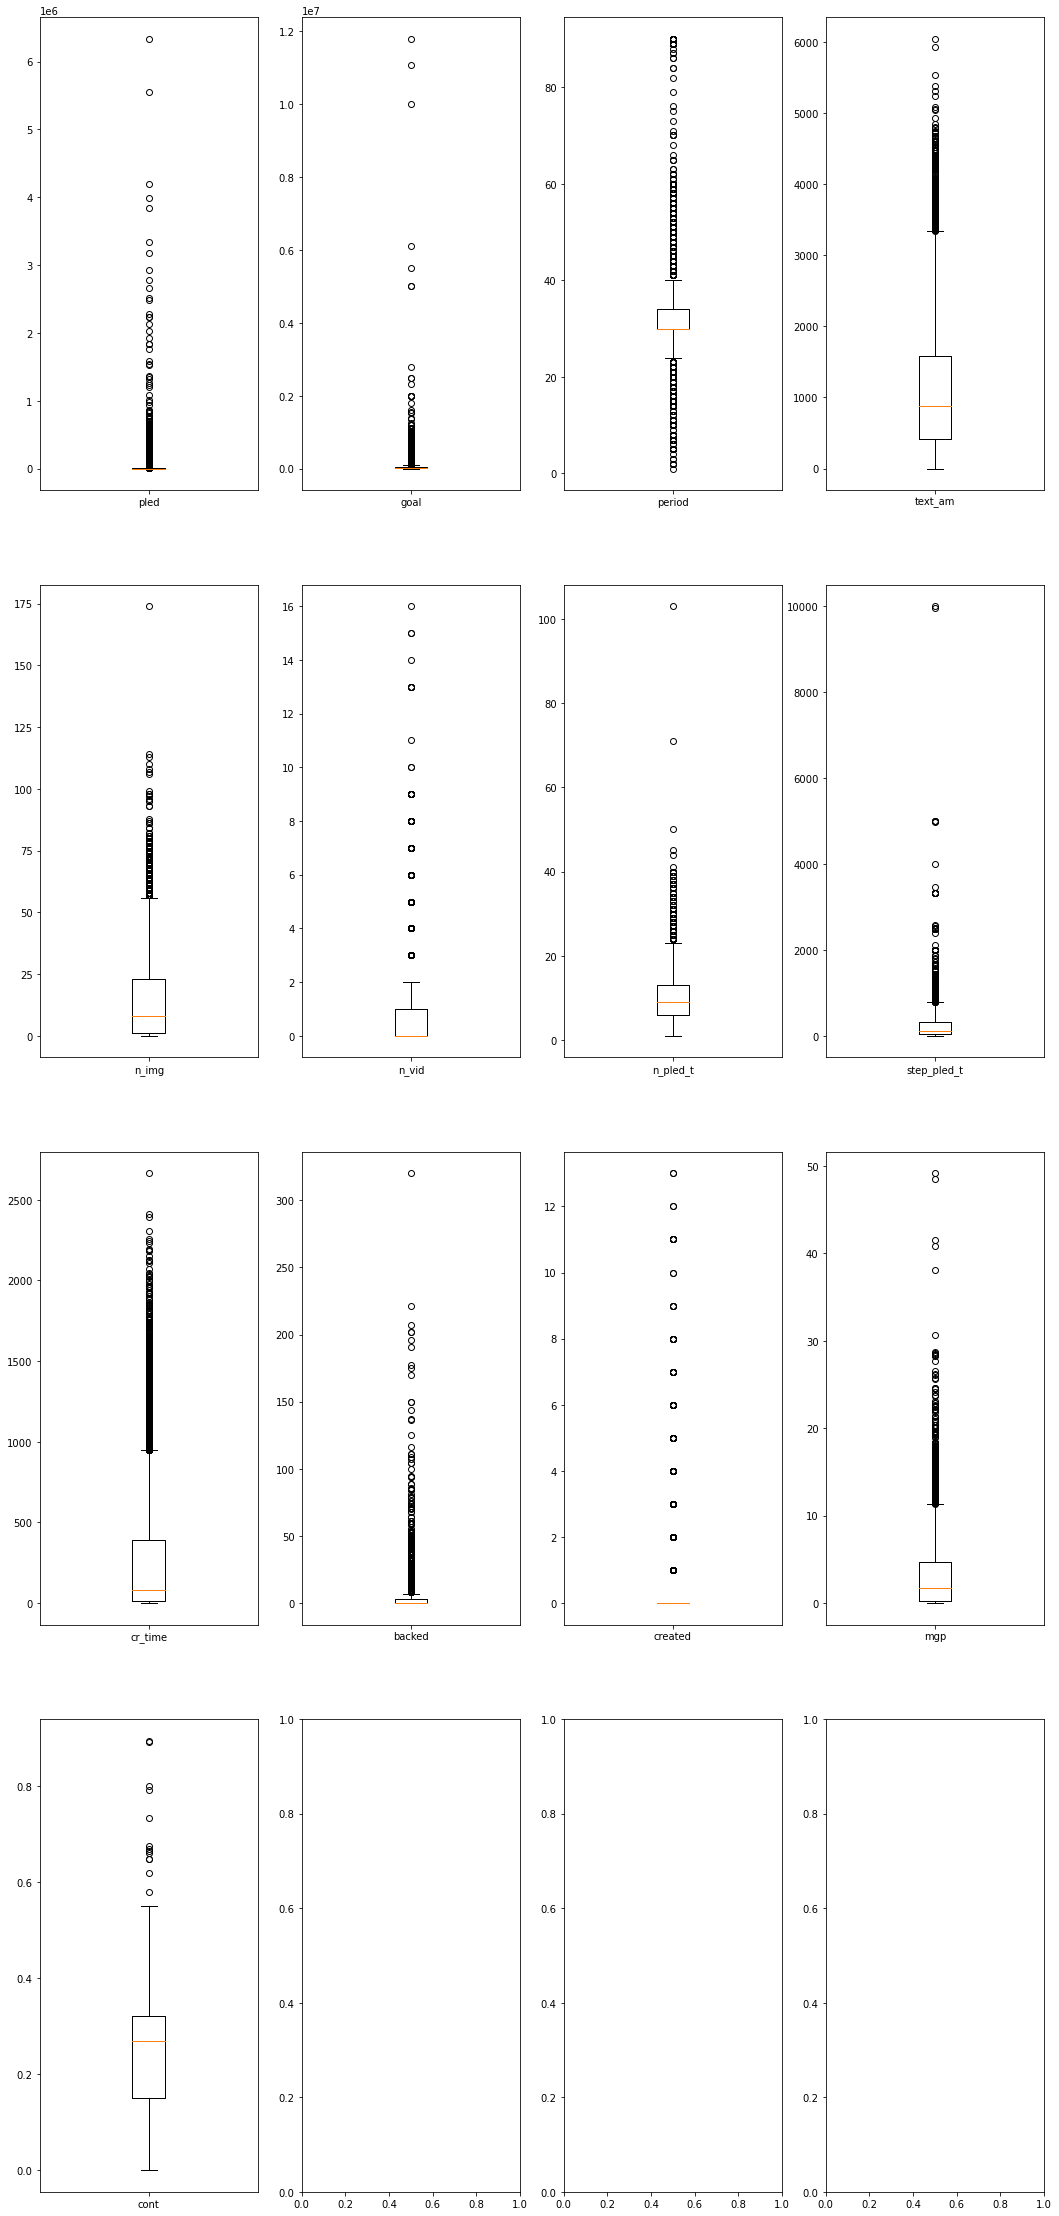

In [86]:
draw_boxplots(df, numeric_columns)

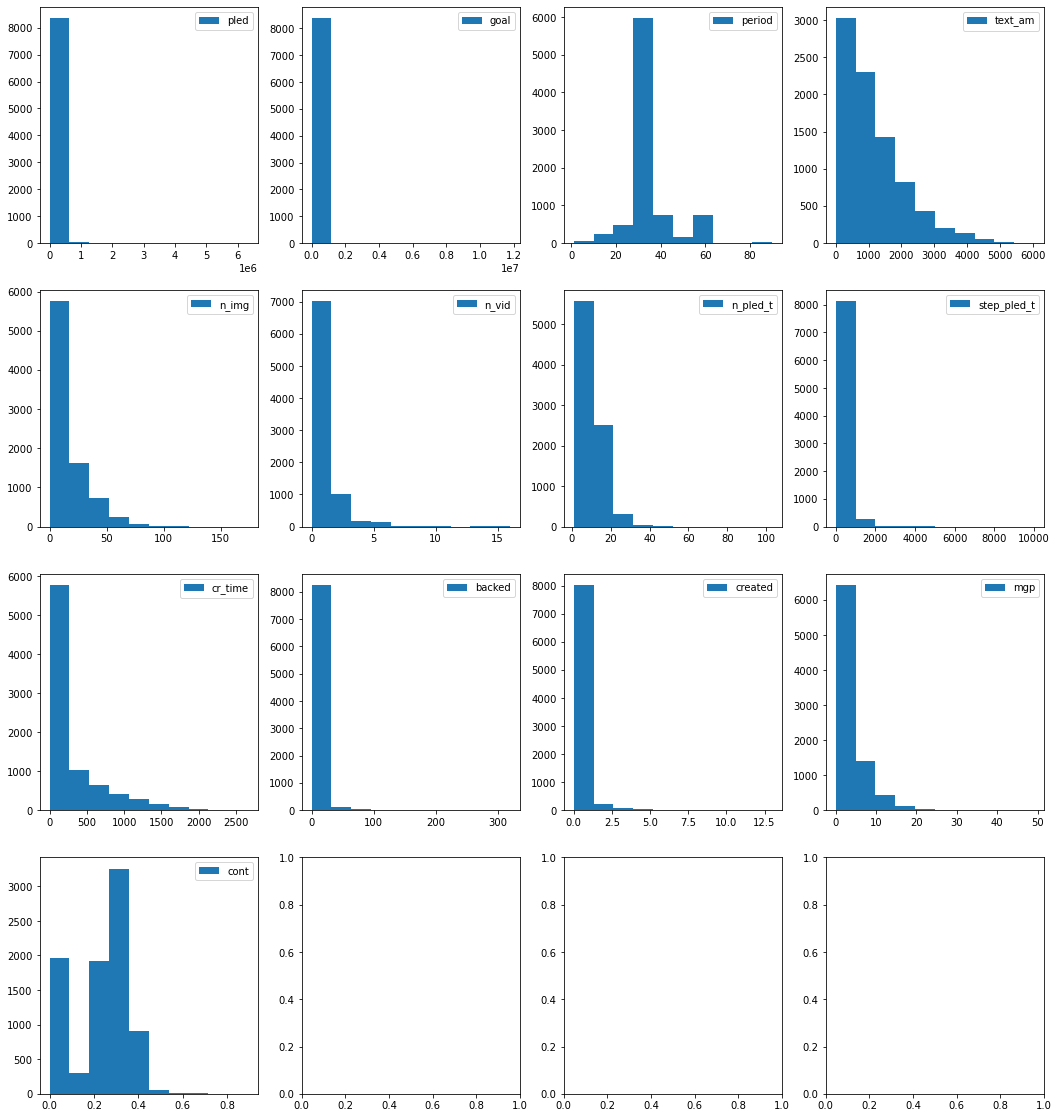

In [87]:
draw_hist(df, numeric_columns, 'bar')

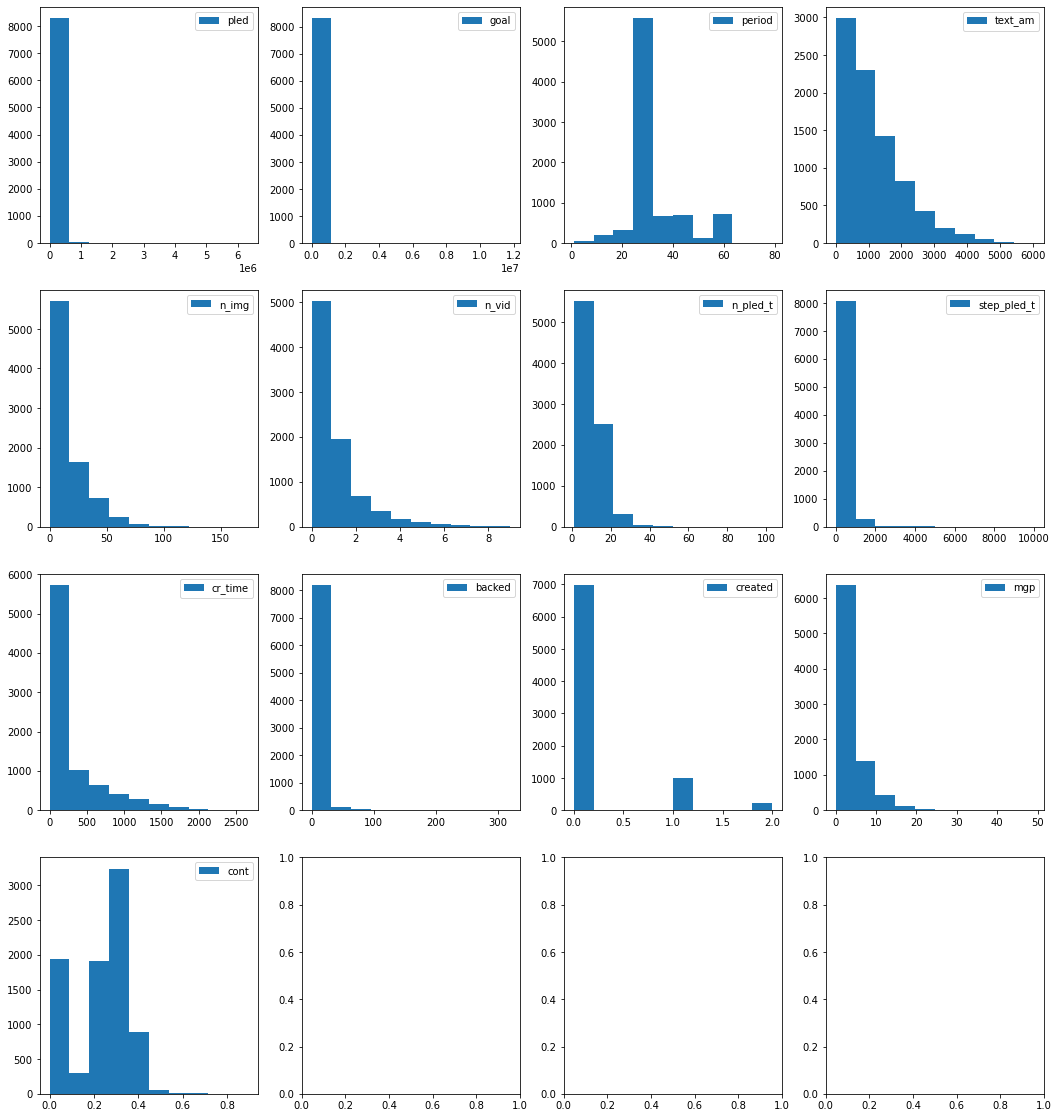

In [92]:
# Remove emissions
df = data
df = df[df['goal'] > 5]
df = df[df['period'] < 80]
df = df[df['n_vid'] < 10]
df['created'].fillna(0, inplace=True)
df['site'].fillna('', inplace=True)

# Using 3 sigmas rule
n_sigmas = 3

created_std = df['created'].std() # Taken from description
created_mean = df['created'].mean()
df2 = df.copy()
df2['created'] = df['created'][(df['created'] >= created_mean - created_std * n_sigmas) & (df['created'] <= created_mean + created_std * n_sigmas)]

draw_hist(df2, numeric_columns, 'bar')

In [89]:
df.shape

(8357, 39)

In [94]:
df.isna().sum()

Unnamed: 0      0
URL             0
pled            0
goal            0
date            0
period          0
status          0
text_am         0
n_img           0
n_vid           0
n_pled_t        0
min_pled_t      0
max_pled_t      0
mean_pled_t     0
step_pled_t     0
cr_time         0
backed          0
created         0
site            0
rpg             0
platformer      0
shooter         0
fighting        0
survival        0
horror          0
strategy        0
arcade          0
simulator       0
mmo             0
indie           0
action          0
quest           0
adventure       0
mgp             0
cont            0
curr            0
succsess        0
is_site         0
success_rate    0
dtype: int64

In [101]:
# Чекаем коеффициенты линейной регрессии - есть контакт!
model = LinearRegression()
scaler = StandardScaler()

X_train, x_test, y_train, y_test = train_test_split(df[numeric_columns[2:] + binary_columns], df[target_column], train_size=0.8)

scaler.fit(X_train)
trian_inp = scaler.transform(X_train)

In [102]:
model.fit(trian_inp, y_train)

preds = model.predict(trian_inp)

mean_squared_error(preds, y_train)

80.65072395024598

In [103]:
test_inp = scaler.transform(x_test)
preds = model.predict(test_inp)

mean_squared_error(preds, y_test)

3.5294672456992773

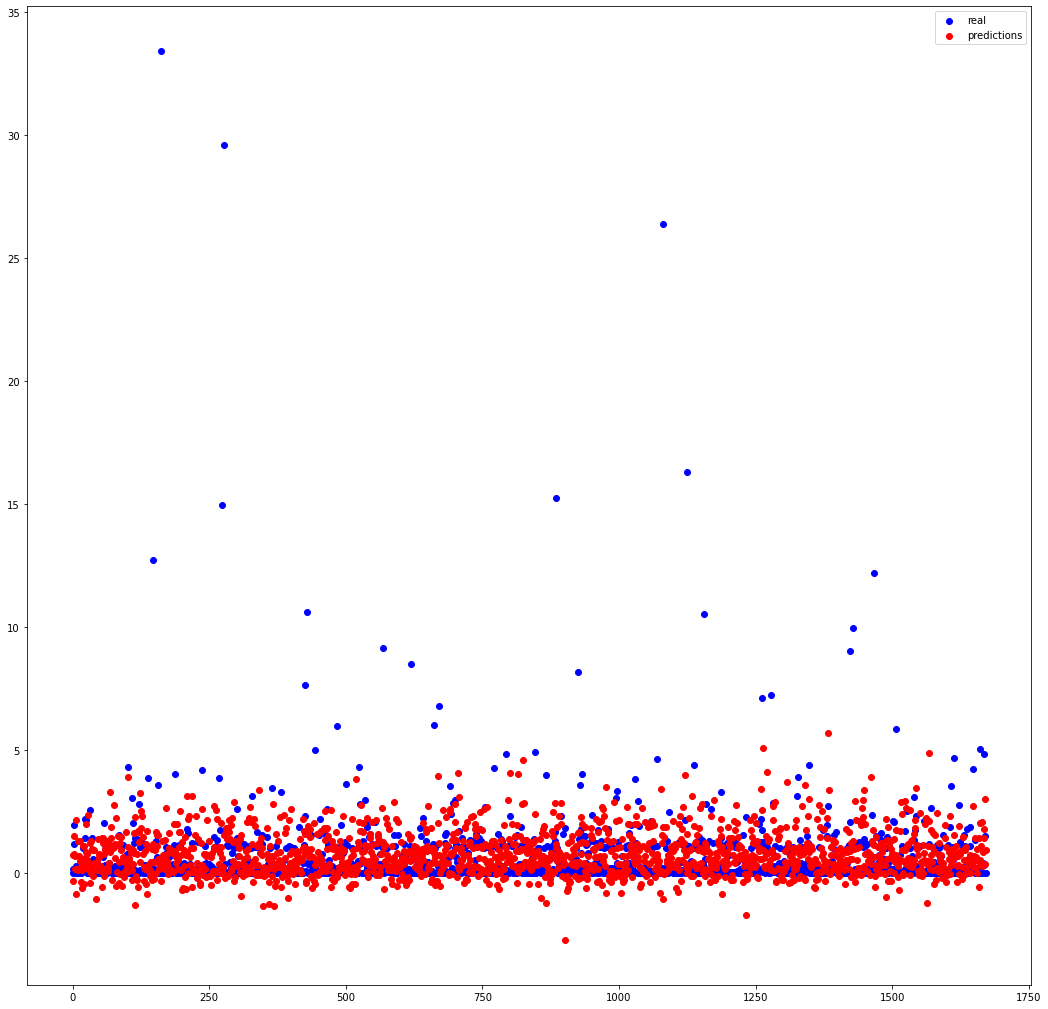

In [104]:
plt.figure(figsize=(18, 18))
plt.scatter(np.arange(len(y_test)), y_test, c='blue', label='real')
plt.scatter(np.arange(len(preds)), preds, c='red', label='predictions')
plt.legend()

In [40]:
{df[numeric_columns[2:] + binary_columns].columns[i]: model.coef_[i] for i in range(len(model.coef_))}

AttributeError: 'LinearRegression' object has no attribute 'coef_'

In [105]:
df[numeric_columns[2:] + binary_columns + [target_column]].corr()['success_rate']

period         -0.018437
text_am         0.025243
n_img           0.040556
n_vid           0.059922
n_pled_t        0.017352
step_pled_t    -0.013159
cr_time         0.059528
backed          0.030444
created         0.027212
mgp             0.047764
cont            0.033065
rpg             0.024228
platformer      0.024974
shooter        -0.009740
fighting       -0.002294
survival       -0.008708
horror          0.018623
strategy       -0.006762
arcade         -0.000877
simulator       0.009971
mmo            -0.007219
indie           0.013104
action         -0.002017
quest           0.024942
adventure       0.019365
is_site         0.032454
success_rate    1.000000
Name: success_rate, dtype: float64

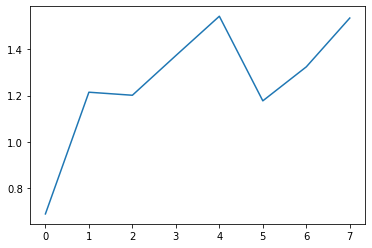

In [106]:
ys = []
for i in range(8):
    ys.append(df[df['created'] == i]['success_rate'].mean())
plt.plot(np.arange(8), ys)

In [107]:
df['cr_time'].value_counts()

1       217
0       202
2       200
3       188
4       167
       ... 
1574      1
1159      1
1078      1
498       1
703       1
Name: cr_time, Length: 1385, dtype: int64

In [108]:
# Описательная статистика
df[numeric_columns].describe()

,pled,goal,period,text_am,n_img,n_vid,n_pled_t,step_pled_t,cr_time,backed,created,mgp,cont
count,8.357000e+03,8.357000e+03,8357.000000,8357.000000,8357.000000,8357.000000,8357.000000,8357.000000,8357.000000,8357.000000,8357.000000,8357.000000,8357.000000
mean,2.335218e+04,5.514797e+04,33.517411,1129.202106,14.382554,0.747158,10.053368,248.295041,278.823501,3.739021,0.270193,3.230619,0.225055
std,1.731903e+05,2.744785e+05,10.189215,912.689831,16.601696,1.272229,5.914403,379.356117,399.497355,11.787206,0.863597,4.060377,0.137365
min,0.000000e+00,7.910000e+00,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.800000e+01,3.638000e+03,30.000000,418.000000,1.000000,0.000000,6.000000,31.876000,15.000000,0.000000,0.000000,0.249422,0.152170
50%,7.720000e+02,1.000000e+04,30.000000,881.000000,8.000000,0.000000,9.000000,106.102000,82.000000,0.000000,0.000000,1.799280,0.269255
75%,6.432000e+03,3.850000e+04,33.000000,1591.000000,23.000000,1.000000,13.000000,333.300000,388.000000,3.000000,0.000000,4.702558,0.322199
max,6.333295e+06,1.179675e+07,79.000000,6042.000000,174.000000,9.000000,103.000000,9999.000000,2664.000000,320.000000,13.000000,49.141376,0.894847


In [109]:
df[numeric_columns].mode()

,pled,goal,period,text_am,n_img,n_vid,n_pled_t,step_pled_t,cr_time,backed,created,mgp,cont
0,0.0,10000.0,30,330,0,0,8,0.0,1,0,0,0.0,0.0


0.08039797141561764

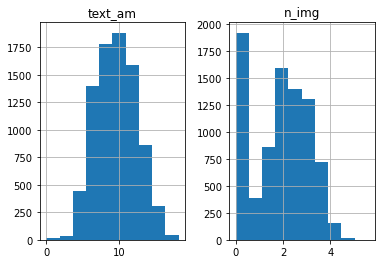

In [110]:
new_set = df[['text_am', 'n_img']]
(new_set ** (1 / 3)).hist()
None
df[df['n_img'] == 0]['success_rate'].mean()